<a href="https://colab.research.google.com/github/MJMortensonWarwick/AAMA/blob/main/3_2_bayesian_methods_%26_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Methods and Machine Learning

Carrying on from our previous Notebook, we apply the Bayesian approach to a standard ML approach ... the linear regression. Ultimately both a frequentist and a Bayesian implementation have the same core goal in an ML framework - to build a model to estimate an unseen target value
($y$) from a set of features ($X$) - and most of elements of the workflow involved will remain the same. The key difference is in how they achieve this (i.e. the models).

The frequentist interpretation of linear regression is given by the following formula:<br><br>
$Y = \alpha + \beta X + e$<br><br>
... that is to say that given some set of $X$ values we can learn some parameters $\alpha$ and $\beta$ (one $\beta$ value for each feature/$X$) that can predict a corresponding target value ($Y$), subject to some error ($e$). Our goal is to find values for these parameters that minimise error at prediction time.

Let's compare this with the Bayesian interpretation:<br><br>
$Y = 𝓝\hspace{0.1cm}(\beta X + \sigma^2)$<br><br>
In this representation we consider $Y$ to be a normal distribution (our posterior) with $\mu = \beta X$ and some standard deviation ($\sigma^2$). We can think of $\sigma^2$ as basically the error term in the frequentist version .... that is that our line is fit to the values of $\alpha + \beta X$ and any gap between the line and the datapoints are the $\sigma^2$ of the model.

Further to this, while the values of $\alpha$ and $\beta$ are fixed values (point estimates) in the frequentist framework, for a Bayesian they are just parameters from an unknown distribution. Rather than finalising on a single value for each, instead we create a distribution of likely values each could take which, being a Gaussian distribution, will have a higher probability density around the mean ($\mu$).

At prediction we could use the mean of each parameter's distribution (i.e. the posterior distibutions for $\alpha$ and $\beta$) to make a single prediction - thus building a model that is a close approximation of the one a frequentist would build (at prediction time at least), but more likely we will make multiple predictions drawing samples from the distributions of each parameter. These multiple predictions can then be averaged to produce a single estimate for $Y$. In many ways we can consider the Bayesian approach, if executed in this fashion, as an ensemble model where we effectively build multiple models at prediction time by drawing different values for each parameter based on the probability densities created.

If this has all got a bit complicated, let's simplify as the following:
1. In a Bayesian model we don't treat our parameters as single values and instead create a probability distribution for each. In linear regression this means a probability distribution for $\alpha$ and for each $\beta$.
2. Rather than treating error as simply a by product of the model, we explicitly model error as another parameter ($\sigma^2$), and therefore as another probability distribution.
3. We learn the model by finding good distributions for each parameter using MCMC sampling (previous Notebook).
4. Rather than creating a single estimate for $Y$ we in fact create a probability distribution (the model's posterior) with multiple potential values, but with a probability mass centred around the mean of the distribution ($\mu$).
5. At prediction time the model works like an ensemble by making multiple predictions of the target ($Y$) using different parameters drawn from each parameter's posterior distribution. Our predictions can then be averaged to make a final prediction.

Let's see it in action!


In [ ]:
from google.colab import files
files.upload()

Saving reg.csv to reg.csv


{'reg.csv': b'\xef\xbb\xbfx0,x1,x2,Y\r\n52,60,75,201\r\n61,73,77,203\r\n63,69,73,192\r\n63,70,77,214\r\n54,65,85,205\r\n55,67,89,206\r\n70,81,90,239\r\n56,77,90,239\r\n75,85,90,238\r\n62,94,80,243\r\n67,78,85,246\r\n80,83,83,242\r\n70,97,101,244\r\n66,88,98,250\r\n83,88,98,266\r\n76,76,102,238\r\n68,69,86,242\r\n67,70,86,249\r\n87,80,92,277\r\n70,88,98,267\r\n84,101,101,291\r\n78,99,106,286\r\n93,99,107,278\r\n74,93,102,289\r\n84,99,104,303\r\n91,89,116,287\r\n85,88,116,314\r\n87,93,98,289\r\n85,82,113,297\r\n88,98,115,294\r\n95,90,124,316\r\n104,96,128,319\r\n116,104,121,344\r\n111,98,121,340\r\n99,112,123,345\r\n103,121,114,337\r\n93,129,127,336\r\n92,106,115,334\r\n101,104,128,338\r\n95,104,116,336\r\n105,101,121,347\r\n94,112,118,345\r\n103,122,127,364\r\n107,123,147,389\r\n128,132,150,403\r\n133,121,141,382\r\n120,129,144,386\r\n117,128,134,365\r\n107,125,140,366\r\n106,123,150,380\r\n124,128,154,372\r\n113,122,131,369\r\n106,122,143,386\r\n115,124,144,369\r\n131,145,145,403\r\n13

In [ ]:
import pandas as pd

df = pd.read_csv('reg.csv')

X = df[['x0', 'x1', 'x2']].to_numpy()
y = df[['Y']].to_numpy().ravel()

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(159, 3)
(40, 3)
(159,)
(40,)


To this point we haven't done anything we haven't before. We've imported a dataset of three features ($X_0, X_1$ and $X_2$), and a set of target values ($Y$). We've split these into training and test (80/20).

In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as bayes_LR:
    a = pm.Normal('intercept', 0, 1)
    b0 = pm.Normal('coeff0', 0, 1)
    b1 = pm.Normal('coeff1', 0, 1)
    b2 = pm.Normal('coeff2', 0, 1)
    s = pm.Exponential('error', 0.01)

    x0_ = pm.Data('features0', X_train[:, 0], mutable=True)
    x1_ = pm.Data('features1', X_train[:, 1], mutable=True)
    x2_ = pm.Data('features2', X_train[:, 2], mutable=True)

    obs = pm.Normal('observation', a + b0*x0_ + b1*x1_ + b2*x2_, s, observed=Y_train, shape=x0_.shape)

    trace = pm.sample(5000, random_seed=123, return_inferencedata=True)

Here we have specified our model. Much of this is as with the previous Notebook but obviously updated to our linear regression problem. We have specified $\alpha$ and $\beta$ as non-informative Gaussian distributions (with $\mu=0$ and $\sigma^2$ = 1).

For the error (s) we have used an exponential distribution. Error ($\sigma^2$) must be a positive value (negative error makes no sense) so we need a distribution that only allows this. The exponential fits that bill, although other contenders would be the gamma or a half-normal. The exponential takes a single parameter ($\lambda$) which determines the length of the tail. A lower value, as we have chosen, suggests a low amount of error (wishful thinking maybe).

After this we have split our features into three separate data containers (_pm.Data_). This allows us to later replace the data in the containers with our test data to make predictions.

Finally, we model $Y$ as a Gaussian with the regression formula as $\mu$ and our error variable as $\sigma^2$. We also pass the generated data as 'observed' (same as with the work in the previous Notebook).

Once the model is fit, again using _pm.Sample_ as we did previously, we can inspect the posteriors:

Summary DF


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept   0.788  0.977  -1.036    2.605      0.011    0.009    8157.0   
coeff0      1.488  0.092   1.319    1.663      0.001    0.001    5912.0   
coeff1      0.688  0.103   0.480    0.869      0.001    0.001    4942.0   
coeff2      0.850  0.087   0.688    1.012      0.001    0.001    5665.0   
error      15.236  0.868  13.681   16.899      0.010    0.007    7853.0   

           ess_tail  r_hat  
intercept    6649.0    1.0  
coeff0       6016.0    1.0  
coeff1       5026.0    1.0  
coeff2       5844.0    1.0  
error        6783.0    1.0  


HDI
[[<Axes: title={'center': 'intercept'}>
  <Axes: title={'center': 'coeff0'}> <Axes: title={'center': 'coeff1'}>]
 [<Axes: title={'center': 'coeff2'}> <Axes: title={'center': 'error'}>
  <Axes: >]]


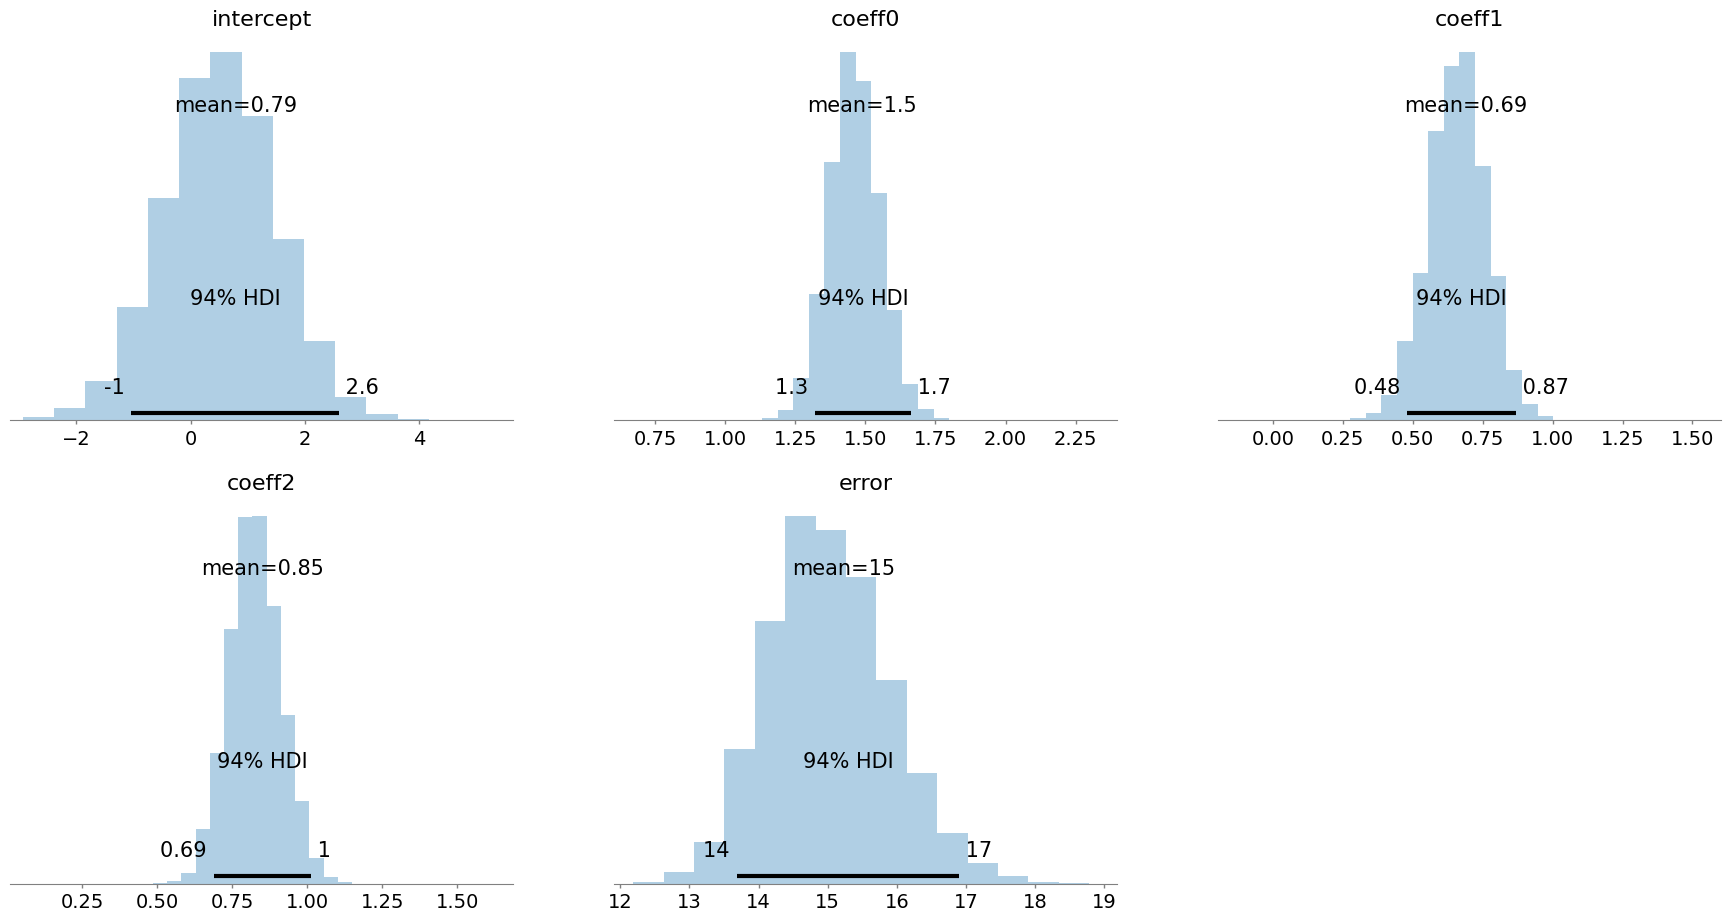

In [ ]:
with bayes_LR:
    print("Summary DF")
    print(az.summary(trace))
    print("\n")
    print("HDI")
    print(az.plot_posterior(trace, kind="hist"));

These outputs are the same as we saw previously, just there are more of them as we have a lot more distributions to estimate. Again our model has good $\hat{R}$ values and no obvious problems. We have mean estimates for each of our $\alpha$ and $\beta$ parameters. Most of our $\beta$ weights our model is fairly condifent about (narrow peaks and only about 0.3-0.4 variation in our 94% HDI) but $\alpha$ is a little less certain and not insubstantial error.

With the model specified / parameters learned, we can start predicting:

In [ ]:
with bayes_LR:
    pm.set_data({'features0': X_test[:, 0], 'features1': X_test[:, 1], 'features2': X_test[:, 2]})
    posterior = pm.sample_posterior_predictive(trace);

Here we return to our model and update the data containers with the values in _X\_test._ After this we can use our posterior in predictive mode.

In [ ]:
import pandas as pd

y_hat = posterior.posterior_predictive['observation'].mean(('chain', 'draw'))
y_pred = pd.DataFrame(y_hat)
y_pred.head(10)

,0
0,281.161429
1,848.133587
2,486.565600
3,740.708409
4,541.879091
5,364.368306
6,772.688373
7,653.615715
8,336.274349
9,738.883971


This code should be fairly self-explanatory. We add the generated predictions into a dataframe. Our dataframe is 100 rows (although we print only 10), representing our average predicting for X\_test. However, these numbers (our $\hat{Y}$ predictions) are only really meaningful in comparison to the real $Y$ values.

Let's buid a dataframe to compare the two:

In [ ]:
y_pred["Pred"] = y_hat.values
y_pred["Real"] = Y_test
y_pred["SE"] = (y_pred["Real"] - y_pred["Pred"]) **2
y_pred[["Real", "Pred", "SE"]].head(10)

,Real,Pred,SE
0,291,281.161429,96.797479
1,862,848.133587,192.277411
2,497,486.565600,108.876707
3,741,740.708409,0.085026
4,552,541.879091,102.432801
5,369,364.368306,21.452590
6,776,772.688373,10.966873
7,666,653.615715,153.370518
8,340,336.274349,13.880472
9,751,738.883971,146.798166


Overall our predictions look pretty good. Some error, but we saw this in our error distribution ($\sigma^2$) earlier.

With these metrics calculated we can get the RMSE for our model:

In [ ]:
import math

rmse = math.sqrt(y_pred.SE.mean())
print(f'RMSE (Bayesian model) = {round(rmse, 4)}')

RMSE (Bayesian model) = 14.5093


##TL;DR
We have seen a Bayesian implementation of linear regression and some of the benefits it can bring. We have fitted a model that seemingly predicts fairly well (only 14.5 $RMSE$) all the while we have Bayesian estimates around our parameters and 94% HDIs on what our parameters might be. I.e. we have a model that performs as it should, and we also have some degree of knowledge about how uncertain our model is, and potential other parameters. Good work! 😗